In [1]:
import pandas as pd
import json
import nltk

nltk.download("wordnet")
from nltk.tokenize import word_tokenize
import numpy

[nltk_data] Downloading package wordnet to /Users/veser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# First part

In [4]:
with open("interactions_v2.json", encoding="cp437", errors="ignore"
) as json_file:
    data = json.load(json_file)

In [5]:
df = pd.DataFrame(data)
df.head()

,confidence,interaction,sol_id,interaction_id
0,2,"[{'role': 'system', 'content': 'Answer in engl...",1000851,4747078
1,4,"[{'role': 'system', 'content': 'You are a phys...",1000851,4390722
2,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4967894
3,5,"[{'role': 'user', 'content': 'Pour encoder la ...",1001199,4944321
4,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4039807


# Information Construction

### Create label positive and negative

In [6]:
def createLabel(example):
    if example["confidence"] > 3:
        return 1
    else:
        return 0


df["label"] = df.apply(createLabel, axis=1)
df.head()

,confidence,interaction,sol_id,interaction_id,label
0,2,"[{'role': 'system', 'content': 'Answer in engl...",1000851,4747078,0
1,4,"[{'role': 'system', 'content': 'You are a phys...",1000851,4390722,1
2,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4967894,1
3,5,"[{'role': 'user', 'content': 'Pour encoder la ...",1001199,4944321,1
4,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4039807,1


### Create Chat format

In [7]:
r2t = {"system": "|SYS|", "user": "|USER|", "assistant": "|ASSIS|"}

In [8]:
def createChat(example):
    interactions = example["interaction"]
    all_entries = []
    for interaction in interactions:
        role = r2t[interaction["role"]]
        if role == "|SYS|":
            if len(interaction["content"]) != 0:
                entry = "".join(f"{role} " + interaction["content"] + "\n\n")
            else:
                entry = ""
        elif role == "|USER|":
            entry = "".join(f"{role} " + interaction["content"] + "\n\n")
        elif role == "|ASSIS|":
            entry = "".join(f"{role} " + interaction["content"] + "\n\n")

        all_entries.append(entry)
    chat = "".join(all_entries)
    return chat


df["chat"] = df.apply(createChat, axis=1)

### Metrics of Label and confidence

In [9]:
value_counts = df["label"].value_counts()
print(value_counts)

label
1    7281
0    3279
Name: count, dtype: int64


In [10]:
value_counts = df["confidence"].value_counts()
print(value_counts)

confidence
5    4456
4    2825
3    1752
2     840
1     561
0     126
Name: count, dtype: int64


### Generate Token length

In [11]:
df["length"] = df.apply(lambda x: len(word_tokenize(x["chat"])), axis=1)
df["number_split"] = df.apply(lambda x: x["chat"].count("|SYS|"), axis=1)

In [12]:
df.head()

,confidence,interaction,sol_id,interaction_id,label,chat,length,number_split
0,2,"[{'role': 'system', 'content': 'Answer in engl...",1000851,4747078,0,|SYS| Answer in english. Show your thinking st...,955,1
1,4,"[{'role': 'system', 'content': 'You are a phys...",1000851,4390722,1,|SYS| You are a physics teacher. You always ch...,891,1
2,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4967894,1,|SYS| QCM\n\n|USER| Pour encoder la séquence d...,172,1
3,5,"[{'role': 'user', 'content': 'Pour encoder la ...",1001199,4944321,1,|USER| Pour encoder la séquence de lettres ABC...,248,0
4,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4039807,1,|SYS| QCM\n\n|USER| Pour encoder la séquence d...,207,1


### 1. Separate by label

In [13]:
df_positive = df[df["label"] == 1]
df_negative = df[df["label"] == 0]

In [14]:
print("Positive Chats:\n\n")

print("more than 2048:", len(df_positive[df_positive["length"] > 2048]))
print(
    "more than 1024:",
    len(df_positive[(df_positive["length"] <= 2048) & (df_positive["length"] > 1024)]),
)
print(
    "more than  512:",
    len(df_positive[(df_positive["length"] <= 1024) & (df_positive["length"] > 512)]),
)
print("less than  512:", len(df_positive[df_positive["length"] <= 512]))

print("\n", "-" * 20)
print("\nNegative Chats:\n\n")

print("more than 2048:", len(df_negative[df_negative["length"] > 2048]))
print(
    "more than 1024:",
    len(df_negative[(df_negative["length"] <= 2048) & (df_negative["length"] > 1024)]),
)
print(
    "more than  512:",
    len(df_negative[(df_negative["length"] <= 1024) & (df_negative["length"] > 512)]),
)
print("less than  512:", len(df_negative[df_negative["length"] <= 512]))

Positive Chats:


more than 2048: 190
more than 1024: 777
more than  512: 1820
less than  512: 4494

 --------------------

Negative Chats:


more than 2048: 160
more than 1024: 636
more than  512: 1107
less than  512: 1376


- Now we can see that the ratio is very similar for both cases, with that in mind, we are going to drop all the rows that are over 2048, from the original dataframe

In [15]:
df[df["length"] > 2048]

,confidence,interaction,sol_id,interaction_id,label,chat,length,number_split
6,3,"[{'role': 'user', 'content': 'Q: Which of the ...",1001417,4119562,0,|USER| Q: Which of the following functions rea...,2174,0
73,3,"[{'role': 'system', 'content': 'Assume the rol...",1016982,4454059,0,|SYS| Assume the role of a highly knowledgeabl...,3112,1
162,3,"[{'role': 'system', 'content': 'Assume the rol...",1039303,4515326,0,|SYS| Assume the role of a highly knowledgeabl...,2123,1
186,5,"[{'role': 'system', 'content': 'Assume the rol...",1046010,4329839,1,|SYS| Assume the role of a highly knowledgeabl...,2602,1
272,4,"[{'role': 'system', 'content': 'Assume the rol...",1064292,4962710,1,|SYS| Assume the role of a highly knowledgeabl...,2594,1
...,...,...,...,...,...,...,...,...
10436,3,"[{'role': 'user', 'content': 'Q: Which of the ...",2980105,4781439,0,|USER| Q: Which of the following functions rea...,2507,0
10459,3,"[{'role': 'user', 'content': 'Q: Which of the ...",2983851,4577236,0,|USER| Q: Which of the following functions rea...,2172,0
10462,5,"[{'role': 'user', 'content': 'Q: Which of the ...",2984454,4933348,1,|USER| Q: Which of the following functions rea...,2873,0
10511,3,"[{'role': 'user', 'content': 'Q: Which of the ...",2990995,4078501,0,|USER| Q: Which of the following functions rea...,2139,0


In [16]:
df = df[df["length"] <= 2048]
df

,confidence,interaction,sol_id,interaction_id,label,chat,length,number_split
0,2,"[{'role': 'system', 'content': 'Answer in engl...",1000851,4747078,0,|SYS| Answer in english. Show your thinking st...,955,1
1,4,"[{'role': 'system', 'content': 'You are a phys...",1000851,4390722,1,|SYS| You are a physics teacher. You always ch...,891,1
2,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4967894,1,|SYS| QCM\n\n|USER| Pour encoder la séquence d...,172,1
3,5,"[{'role': 'user', 'content': 'Pour encoder la ...",1001199,4944321,1,|USER| Pour encoder la séquence de lettres ABC...,248,0
4,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4039807,1,|SYS| QCM\n\n|USER| Pour encoder la séquence d...,207,1
...,...,...,...,...,...,...,...,...
10555,1,"[{'role': 'system', 'content': 'En supposant q...",2999633,4967912,0,|SYS| En supposant que vous êtes un expert en ...,143,1
10556,5,"[{'role': 'system', 'content': 'Act as a compu...",2999633,4198754,1,|SYS| Act as a computer science tutor.\n\n|USE...,897,1
10557,5,"[{'role': 'system', 'content': 'Could you plea...",2999828,4834259,1,|SYS| Could you please answer the multiple cho...,199,1
10558,4,"[{'role': 'system', 'content': 'From now on, y...",2999828,4823002,1,"|SYS| From now on, you will act as a computati...",212,1


In [127]:
df.to_json("../data/interactions_v3.json", orient="records", indent=4)

# Second part

In [17]:
with open(
    "../data/base/interactions_v3.json", encoding="cp437", errors="ignore"
) as json_file:
    data = json.load(json_file)
df = pd.DataFrame(data)
df.head()

,confidence,interaction,sol_id,interaction_id,label,chat,length,number_split
0,2,"[{'role': 'system', 'content': 'Answer in engl...",1000851,4747078,0,|SYS| Answer in english. Show your thinking st...,955,1
1,4,"[{'role': 'system', 'content': 'You are a phys...",1000851,4390722,1,|SYS| You are a physics teacher. You always ch...,891,1
2,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4967894,1,|SYS| QCM\n\n|USER| Pour encoder la séquence d...,172,1
3,5,"[{'role': 'user', 'content': 'Pour encoder la ...",1001199,4944321,1,|USER| Pour encoder la séquence de lettres ABC...,248,0
4,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4039807,1,|SYS| QCM\n\n|USER| Pour encoder la séquence d...,207,1


In [18]:
df['label'].value_counts()

label
1    7091
0    3119
Name: count, dtype: int64

actually we cluld do the same for 1024 

### 1.1 Separate if split > 1

In [64]:
value_counts = df["number_split"].value_counts()
print(value_counts)

number_split
1    7328
0    2404
2     160
5      97
6      90
7      83
3      36
4      11
9       1
Name: count, dtype: int64


1. split possible

In [65]:
df_sub = df[df["number_split"] > 1]

In [66]:
value_counts = df_sub["label"].value_counts()
print(value_counts)

label
1    354
0    124
Name: count, dtype: int64


Amount of rows by token interval:



In [67]:
print(len(df_sub[(df_sub["length"] <= 2048) & (df_sub["length"] > 1024)]))
print(len(df_sub[(df_sub["length"] <= 1024) & (df_sub["length"] > 512)]))
print(len(df_sub[df_sub["length"] <= 512]))

178
260
40


1.1 label for 2048 to 1024

2. less than 1 split possible

In [68]:
df_nom = df[df["number_split"] <= 1]

In [69]:
value_counts = df_nom["label"].value_counts()
print(value_counts)

label
1    6737
0    2995
Name: count, dtype: int64


In [70]:
print(len(df_nom[(df_nom["length"] <= 2048) & (df_nom["length"] > 1024)]))
print(len(df_nom[(df_nom["length"] <= 1024) & (df_nom["length"] > 512)]))
print(len(df_nom[df_nom["length"] <= 512]))

1235
2667
5830


2.1 For tokens between 2048 and 1024

In [71]:
value_counts = df_nom[(df_nom["length"] <= 2048) & (df_nom["length"] > 1024)][
    "label"
].value_counts()
print(value_counts)

label
1    643
0    592
Name: count, dtype: int64


2.2 For tokens between 1024 and 512

In [72]:
value_counts = df_nom[(df_nom["length"] <= 1024) & (df_nom["length"] > 512)][
    "label"
].value_counts()
print(value_counts)

label
1    1632
0    1035
Name: count, dtype: int64


2.3 For less than 512

In [73]:
value_counts = df_nom[df_nom["length"] < 512]["label"].value_counts()
print(value_counts)

label
1    4454
0    1364
Name: count, dtype: int64


With this, we have that the biggest differnce on labels occurs on 0 to 512 interval. 

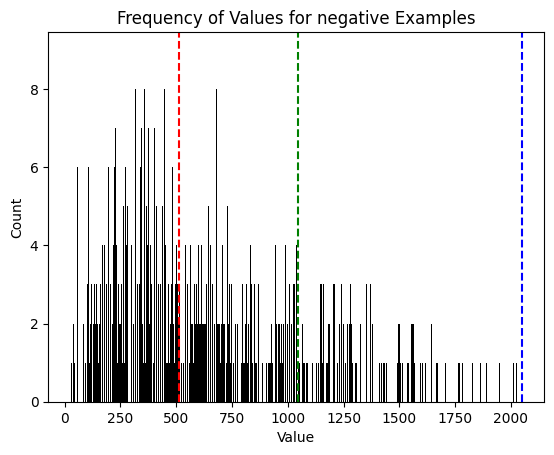

In [74]:
import matplotlib.pyplot as plt

# Count the frequency of each value in 'length' column
value_counts = df_nom["length"][df["label"] == 0].value_counts().sort_index()

# Get the keys and counts for plotting
keys = value_counts.index
counts = value_counts.values

plt.axvline(x=512, color="red", linestyle="--")
plt.axvline(x=1048, color="green", linestyle="--")
plt.axvline(x=2048, color="blue", linestyle="--")
# Plot the values and their counts
plt.bar(keys, counts, color="black")
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Frequency of Values for negative Examples")
plt.show()

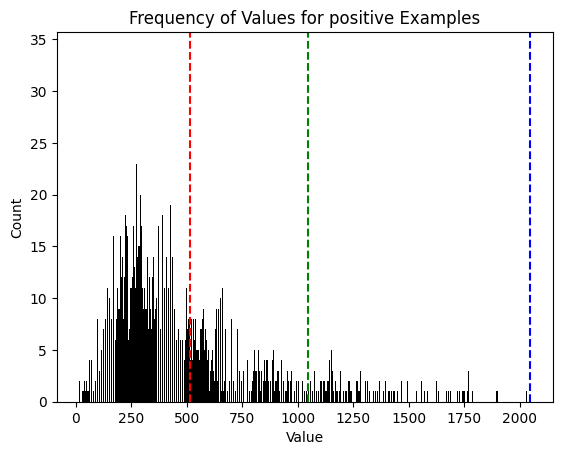

In [75]:
import matplotlib.pyplot as plt

# Count the frequency of each value in 'length' column
value_counts = df_nom["length"][df["label"] == 1].value_counts().sort_index()

# Get the keys and counts for plotting
keys = value_counts.index
counts = value_counts.values

plt.axvline(x=512, color="red", linestyle="--")
plt.axvline(x=1048, color="green", linestyle="--")
plt.axvline(x=2048, color="blue", linestyle="--")
# Plot the values and their counts
plt.bar(keys, counts, color="black")
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Frequency of Values for positive Examples")
plt.show()

In [76]:
# Group the dataframe by interaction_id and calculate sum for 'confidence', mean for 'length'
df_grouped = df.groupby("sol_id").agg({"confidence": "sum", "length": "mean"})
df_grouped.index

Index([1000851, 1001199, 1001417, 1002278, 1002413, 1003280, 1003546, 1004520,
       1005186, 1005379,
       ...
       2996157, 2996320, 2996487, 2997321, 2998144, 2998595, 2999432, 2999488,
       2999633, 2999828],
      dtype='int64', name='sol_id', length=4432)

In [86]:
df1 = df.copy()

In [88]:
df1.set_index("sol_id", inplace=True, drop=False)
df1

,confidence,interaction,sol_id,interaction_id,label,chat,length,number_split
sol_id,,,,,,,,
1000851,2,"[{'role': 'system', 'content': 'Answer in engl...",1000851,4747078,0,|SYS| Answer in english. Show your thinking st...,955,1
1000851,4,"[{'role': 'system', 'content': 'You are a phys...",1000851,4390722,1,|SYS| You are a physics teacher. You always ch...,891,1
1001199,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4967894,1,|SYS| QCM\n\n|USER| Pour encoder la séquence d...,172,1
1001199,5,"[{'role': 'user', 'content': 'Pour encoder la ...",1001199,4944321,1,|USER| Pour encoder la séquence de lettres ABC...,248,0
1001199,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",1001199,4039807,1,|SYS| QCM\n\n|USER| Pour encoder la séquence d...,207,1
...,...,...,...,...,...,...,...,...
2999633,1,"[{'role': 'system', 'content': 'En supposant q...",2999633,4967912,0,|SYS| En supposant que vous êtes un expert en ...,143,1
2999633,5,"[{'role': 'system', 'content': 'Act as a compu...",2999633,4198754,1,|SYS| Act as a computer science tutor.\n\n|USE...,897,1
2999828,5,"[{'role': 'system', 'content': 'Could you plea...",2999828,4834259,1,|SYS| Could you please answer the multiple cho...,199,1


In [89]:
def samples(example):
    # obtain the amount of rows that have the same index
    index = example.name
    df2 = df1.loc[index]
    if type(df2) == pd.core.series.Series:
        return 1
    return len(df2)


df1["total"] = df1.apply(samples, axis=1)

In [90]:
df1["total"].value_counts()

total
3    6507
2    2102
1    1085
4     488
6      18
5      10
Name: count, dtype: int64

In [91]:
def labelDiversity(example):
    # obtain the amount of rows that have the same index
    index = example.name
    df2 = df1.loc[index]
    labels = df2["label"]
    if type(labels) == numpy.int64:
        return labels
    else:
        labels = list(df2["label"].value_counts().to_dict().keys())
        if [0, 1] == labels:
            return 2
        else:
            return labels.pop()


df1["pairs"] = df1.apply(labelDiversity, axis=1)

In [92]:
df1["pairs"].value_counts()

pairs
1    4619
0    3863
2    1728
Name: count, dtype: int64

# Pair JSON files

## Create Pair positive/negative

In [168]:
both = df1[df1["pairs"] == 2]
# both = both.loc[1005186]
both

,confidence,interaction,sol_id,interaction_id,label,chat,length,number_split,total,pairs
sol_id,,,,,,,,,,
1000851,2,"[{'role': 'system', 'content': 'Answer in engl...",1000851,4747078,0,|SYS| Answer in english. Show your thinking st...,955,1,2,2
1000851,4,"[{'role': 'system', 'content': 'You are a phys...",1000851,4390722,1,|SYS| You are a physics teacher. You always ch...,891,1,2,2
1005186,3,"[{'role': 'system', 'content': 'Which of the f...",1005186,4320012,0,|SYS| Which of the following answer is correct...,744,1,3,2
1005186,5,"[{'role': 'system', 'content': 'Please select ...",1005186,4190065,1,|SYS| Please select the correct answer and pro...,276,1,3,2
1005186,2,"[{'role': 'system', 'content': 'Select the cor...",1005186,4669952,0,|SYS| Select the correct answer and detail why...,390,1,3,2
...,...,...,...,...,...,...,...,...,...,...
2998595,3,"[{'role': 'system', 'content': 'Please select ...",2998595,4837798,0,|SYS| Please select the correct answer and pro...,791,1,3,2
2998595,5,"[{'role': 'system', 'content': 'Select the cor...",2998595,4775507,1,|SYS| Select the correct answer and detail why...,433,1,3,2
2998595,3,"[{'role': 'system', 'content': 'Which of the f...",2998595,4594397,0,|SYS| Which of the following answer is correct...,413,1,3,2


In [169]:
list_0 = [f"{col}_0" for col in df1.columns]
list_1 = [f"{col}_1" for col in df1.columns]

In [185]:
# create new dataframe with columns list_0
pairs = pd.DataFrame(columns=list_0 + list_1)
display(pairs)

,confidence_0,interaction_0,sol_id_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,confidence_1,interaction_1,sol_id_1,interaction_id_1,label_1,chat_1,length_1,number_split_1,total_1,pairs_1


In [186]:
import itertools

In [187]:
def creating(example):
    index = example.name
    dfs = both.loc[index]
    # now you have to make to subsets, the ones with label 0 and the ones with label 1
    df_0 = dfs[dfs["label"] == 0]
    df_1 = dfs[dfs["label"] == 1]
    df_0.set_index("interaction_id", inplace=True, drop=False)
    df_1.set_index("interaction_id", inplace=True, drop=False)
    combinations = list(itertools.product(df_0.index, df_1.index))

    for comb in combinations:
        # get the rows from df_0 and df_1 for the current combination
        row_0 = df_0.loc[comb[0]].to_frame().T
        row_1 = df_1.loc[comb[1]].to_frame().T
        row_0.columns = list_0
        row_1.columns = list_1
        row_0.set_index("sol_id_0", inplace=True, drop=False)
        row_1.set_index("sol_id_1", inplace=True, drop=False)

        # add a new row with the lowest df_0 and highest df_1 to a new dataframe
        new_row = pd.concat([row_0, row_1], axis=1)
        # create a new index
        new_row.index = [0]

        # add new_row to pairs dataframe
        global pairs
        pairs = pd.concat([pairs, new_row], ignore_index=True)


both.apply(creating, axis=1)

sol_id
1000851    None
1000851    None
1005186    None
1005186    None
1005186    None
           ... 
2998595    None
2998595    None
2998595    None
2999488    None
2999488    None
Length: 1728, dtype: object

In [188]:
print(len(pairs))
pairs.head()

3336


,confidence_0,interaction_0,sol_id_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,confidence_1,interaction_1,sol_id_1,interaction_id_1,label_1,chat_1,length_1,number_split_1,total_1,pairs_1
0,2,"[{'role': 'system', 'content': 'Answer in engl...",1000851,4747078,0,|SYS| Answer in english. Show your thinking st...,955,1,2,2,4,"[{'role': 'system', 'content': 'You are a phys...",1000851,4390722,1,|SYS| You are a physics teacher. You always ch...,891,1,2,2
1,2,"[{'role': 'system', 'content': 'Answer in engl...",1000851,4747078,0,|SYS| Answer in english. Show your thinking st...,955,1,2,2,4,"[{'role': 'system', 'content': 'You are a phys...",1000851,4390722,1,|SYS| You are a physics teacher. You always ch...,891,1,2,2
2,3,"[{'role': 'system', 'content': 'Which of the f...",1005186,4320012,0,|SYS| Which of the following answer is correct...,744,1,3,2,5,"[{'role': 'system', 'content': 'Please select ...",1005186,4190065,1,|SYS| Please select the correct answer and pro...,276,1,3,2
3,2,"[{'role': 'system', 'content': 'Select the cor...",1005186,4669952,0,|SYS| Select the correct answer and detail why...,390,1,3,2,5,"[{'role': 'system', 'content': 'Please select ...",1005186,4190065,1,|SYS| Please select the correct answer and pro...,276,1,3,2
4,3,"[{'role': 'system', 'content': 'Which of the f...",1005186,4320012,0,|SYS| Which of the following answer is correct...,744,1,3,2,5,"[{'role': 'system', 'content': 'Please select ...",1005186,4190065,1,|SYS| Please select the correct answer and pro...,276,1,3,2


In [189]:
pairs.drop_duplicates(
    subset=["interaction_id_0", "interaction_id_1"], keep="first", inplace=True
)

In [190]:
print(len(pairs))
pairs.head()

1124


,confidence_0,interaction_0,sol_id_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,confidence_1,interaction_1,sol_id_1,interaction_id_1,label_1,chat_1,length_1,number_split_1,total_1,pairs_1
0,2,"[{'role': 'system', 'content': 'Answer in engl...",1000851,4747078,0,|SYS| Answer in english. Show your thinking st...,955,1,2,2,4,"[{'role': 'system', 'content': 'You are a phys...",1000851,4390722,1,|SYS| You are a physics teacher. You always ch...,891,1,2,2
2,3,"[{'role': 'system', 'content': 'Which of the f...",1005186,4320012,0,|SYS| Which of the following answer is correct...,744,1,3,2,5,"[{'role': 'system', 'content': 'Please select ...",1005186,4190065,1,|SYS| Please select the correct answer and pro...,276,1,3,2
3,2,"[{'role': 'system', 'content': 'Select the cor...",1005186,4669952,0,|SYS| Select the correct answer and detail why...,390,1,3,2,5,"[{'role': 'system', 'content': 'Please select ...",1005186,4190065,1,|SYS| Please select the correct answer and pro...,276,1,3,2
8,0,"[{'role': 'system', 'content': 'Act as a PhD-l...",1005946,4817376,0,|SYS| Act as a PhD-level teaching assistant wh...,1420,1,3,2,5,"[{'role': 'system', 'content': 'You are a mach...",1005946,4012210,1,"|SYS| You are a machine learning student, writ...",426,1,3,2
9,3,"[{'role': 'system', 'content': 'You are a univ...",1005946,4219606,0,|SYS| You are a university professor creating ...,200,1,3,2,5,"[{'role': 'system', 'content': 'You are a mach...",1005946,4012210,1,"|SYS| You are a machine learning student, writ...",426,1,3,2


In [191]:
pairs.set_index("sol_id_0", inplace=True, drop=False)
pairs["sol_id"] = pairs["sol_id_0"]
del pairs["sol_id_0"]
del pairs["sol_id_1"]
pairs.to_json("pairs.json", orient="records", indent=4)

In [192]:
pairs

,confidence_0,interaction_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,confidence_1,interaction_1,interaction_id_1,label_1,chat_1,length_1,number_split_1,total_1,pairs_1,sol_id
sol_id_0,,,,,,,,,,,,,,,,,,,
1000851,2,"[{'role': 'system', 'content': 'Answer in engl...",4747078,0,|SYS| Answer in english. Show your thinking st...,955,1,2,2,4,"[{'role': 'system', 'content': 'You are a phys...",4390722,1,|SYS| You are a physics teacher. You always ch...,891,1,2,2,1000851
1005186,3,"[{'role': 'system', 'content': 'Which of the f...",4320012,0,|SYS| Which of the following answer is correct...,744,1,3,2,5,"[{'role': 'system', 'content': 'Please select ...",4190065,1,|SYS| Please select the correct answer and pro...,276,1,3,2,1005186
1005186,2,"[{'role': 'system', 'content': 'Select the cor...",4669952,0,|SYS| Select the correct answer and detail why...,390,1,3,2,5,"[{'role': 'system', 'content': 'Please select ...",4190065,1,|SYS| Please select the correct answer and pro...,276,1,3,2,1005186
1005946,0,"[{'role': 'system', 'content': 'Act as a PhD-l...",4817376,0,|SYS| Act as a PhD-level teaching assistant wh...,1420,1,3,2,5,"[{'role': 'system', 'content': 'You are a mach...",4012210,1,"|SYS| You are a machine learning student, writ...",426,1,3,2,1005946
1005946,3,"[{'role': 'system', 'content': 'You are a univ...",4219606,0,|SYS| You are a university professor creating ...,200,1,3,2,5,"[{'role': 'system', 'content': 'You are a mach...",4012210,1,"|SYS| You are a machine learning student, writ...",426,1,3,2,1005946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993458,0,"[{'role': 'system', 'content': 'Act as a PhD-l...",4830835,0,|SYS| Act as a PhD-level teaching assistant wh...,1353,1,3,2,5,"[{'role': 'system', 'content': 'You are a mach...",4681406,1,"|SYS| You are a machine learning student, writ...",454,1,3,2,2993458
2996157,1,"[{'role': 'system', 'content': 'You are a phys...",4232286,0,|SYS| You are a physics teacher. You always ch...,434,1,2,2,5,"[{'role': 'system', 'content': 'Answer in engl...",4503281,1,|SYS| Answer in english. Show your thinking st...,299,1,2,2,2996157
2998595,3,"[{'role': 'system', 'content': 'Please select ...",4837798,0,|SYS| Please select the correct answer and pro...,791,1,3,2,5,"[{'role': 'system', 'content': 'Select the cor...",4775507,1,|SYS| Select the correct answer and detail why...,433,1,3,2,2998595


## Create Positive examples

In [156]:
positive_df = df1[df1["pairs"] == 1]
positive_df.head()

,confidence,interaction,interaction_id,label,chat,length,number_split,total,pairs
sol_id,,,,,,,,,
1001199,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",4967894,1,|SYS| QCM\n\n|USER| Pour encoder la séquence d...,172,1,3,1
1001199,5,"[{'role': 'user', 'content': 'Pour encoder la ...",4944321,1,|USER| Pour encoder la séquence de lettres ABC...,248,0,3,1
1001199,4,"[{'role': 'system', 'content': 'QCM'}, {'role'...",4039807,1,|SYS| QCM\n\n|USER| Pour encoder la séquence d...,207,1,3,1
1001417,4,"[{'role': 'user', 'content': 'Assume that we h...",4906222,1,|USER| Assume that we have a convolutional neu...,438,0,1,1
1002278,5,"[{'role': 'system', 'content': 'You are a teac...",4150255,1,|SYS| You are a teaching assistant answering q...,397,1,2,1


In [157]:
# create new dataframe with columns list_0
positives = pd.DataFrame(columns=list_1)
display(positives)

,confidence_1,interaction_1,interaction_id_1,label_1,chat_1,length_1,number_split_1,total_1,pairs_1


In [158]:
def creating_positive(example):
    index = example.name
    dfs = positive_df.loc[index]
    # now you have to select the one with higher confidence for 1
    if type(dfs) == pd.core.frame.DataFrame:
        dfs = dfs[dfs["confidence"] == dfs["confidence"].max()]
        dfs = dfs[dfs["length"] == dfs["length"].min()]
    else:
        dfs = dfs.to_frame().T
    # now add to a new dataframe
    dfs.columns = [f"{col}_1" for col in dfs.columns]
    # add df_concat to news
    global positives
    positives = pd.concat([positives, dfs], axis=0)


positive_df.apply(creating_positive, axis=1)

sol_id
1001199    None
1001199    None
1001199    None
1001417    None
1002278    None
           ... 
2998144    None
2998144    None
2999828    None
2999828    None
2999828    None
Length: 4619, dtype: object

In [159]:
len(positives)

4622

In [160]:
positives.drop_duplicates(subset=["interaction_id_1"], keep="first", inplace=True)

In [161]:
len(positives)

2165

In [162]:
len(positives[positives["length_1"] > 512])

531

In [163]:
# negatives conlumn with the index
positives["sol_id"] = positives.index
positives.to_json("positives.json", orient="records", indent=4)
positives

,confidence_1,interaction_1,interaction_id_1,label_1,chat_1,length_1,number_split_1,total_1,pairs_1,sol_id
1001199,5,"[{'role': 'user', 'content': 'Pour encoder la ...",4944321,1,|USER| Pour encoder la séquence de lettres ABC...,248,0,3,1,1001199
1001417,4,"[{'role': 'user', 'content': 'Assume that we h...",4906222,1,|USER| Assume that we have a convolutional neu...,438,0,1,1,1001417
1002278,5,"[{'role': 'system', 'content': 'You are an edu...",4373321,1,|SYS| You are an educational assistant that an...,236,1,2,1,1002278
1002413,5,"[{'role': 'system', 'content': 'You are going ...",4195984,1,|SYS| You are going to assist a student with t...,886,1,1,1,1002413
1004520,5,"[{'role': 'system', 'content': 'You are a teac...",4046168,1,|SYS| You are a teaching assistant answering q...,1105,1,2,1,1004520
...,...,...,...,...,...,...,...,...,...,...
2995485,4,"[{'role': 'user', 'content': 'Consider a binar...",4941748,1,|USER| Consider a binary classification proble...,795,0,1,1,2995485
2996487,5,"[{'role': 'system', 'content': 'Can you provid...",4903887,1,|SYS| Can you provide an explanation for someo...,285,1,1,1,2996487
2997321,5,"[{'role': 'system', 'content': 'Answer the fol...",4951402,1,|SYS| Answer the following question: Integral ...,60,1,2,1,2997321
2998144,5,"[{'role': 'user', 'content': ' Match one of th...",4384945,1,|USER| Match one of the tools (a)-(e) to the ...,81,0,3,1,2998144


## Create Negative examples

In [164]:
negative_df = df1[df1["pairs"] == 0]
negative_df.head()

,confidence,interaction,interaction_id,label,chat,length,number_split,total,pairs
sol_id,,,,,,,,,
1003280,1,"[{'role': 'system', 'content': 'You are going ...",4202957,0,|SYS| You are going to assist a student with t...,1289,1,1,0
1003546,5,"[{'role': 'system', 'content': 'Tu es un profe...",4998890,1,|SYS| Tu es un professeur de physique. Réponds...,655,1,3,0
1003546,2,"[{'role': 'user', 'content': ' Voci une qu...",4629180,0,|USER| \n Voci une question d'un cours de p...,1521,0,3,0
1003546,5,"[{'role': 'user', 'content': 'Pense étape par ...",4505608,1,|USER| Pense étape par étape: D{\'e}terminez l...,1055,0,3,0
1005379,4,"[{'role': 'system', 'content': ' You are a...",4769649,1,|SYS| \n You are a education tutor in a uni...,348,1,2,0


In [165]:
# create new dataframe with columns list_0
negatives = pd.DataFrame(columns=list_0)
display(negatives)

,confidence_0,interaction_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0


In [166]:
def creating(example):
    index = example.name
    dfs = negative_df.loc[index]
    # now you have to select the one with higher confidence for 1
    if type(dfs) == pd.core.frame.DataFrame:
        dfs = dfs[dfs["confidence"] == dfs["confidence"].min()]
        dfs = dfs[dfs["length"] == dfs["length"].min()]
    else:
        dfs = dfs.to_frame().T
    # now add to a new dataframe
    dfs.columns = [f"{col}_0" for col in dfs.columns]
    # add df_concat to news
    global negatives
    negatives = pd.concat([negatives, dfs], axis=0)


negative_df.apply(creating, axis=1)

sol_id
1003280    None
1003546    None
1003546    None
1003546    None
1005379    None
           ... 
2996320    None
2999432    None
2999633    None
2999633    None
2999633    None
Length: 3863, dtype: object

In [167]:
len(negatives)

3863

we delete duplicates and all the number of splits less than 2 because in a previus analysis we noticed that are less than 2% of the data

In [168]:
negatives = negatives[negatives["number_split_0"] < 1]
negatives.drop_duplicates(subset=["interaction_id_0"], keep="first", inplace=True)

In [169]:
len(negatives)

1612

In [170]:
negatives

,confidence_0,interaction_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0
1003280,1,"[{'role': 'system', 'content': 'You are going ...",4202957,0,|SYS| You are going to assist a student with t...,1289,1,1,0
1003546,2,"[{'role': 'user', 'content': ' Voci une qu...",4629180,0,|USER| \n Voci une question d'un cours de p...,1521,0,3,0
1005379,1,"[{'role': 'system', 'content': 'You are going ...",4487546,0,|SYS| You are going to assist the following us...,268,1,2,0
1006805,2,"[{'role': 'system', 'content': 'You are an ass...",4811117,0,|SYS| You are an assistant that teaches Astrop...,833,1,1,0
1007435,2,"[{'role': 'system', 'content': 'Assume you are...",4906852,0,|SYS| Assume you are an expert of software eng...,1218,3,3,0
...,...,...,...,...,...,...,...,...,...
2991176,3,"[{'role': 'system', 'content': 'Respond as an ...",4270463,0,|SYS| Respond as an assistant for a University...,249,1,1,0
2994746,2,"[{'role': 'system', 'content': 'You are a Phys...",4729943,0,|SYS| You are a Physics teacher at EPFL. You a...,411,1,1,0
2996320,3,"[{'role': 'system', 'content': 'Assume you are...",4202500,0,|SYS| Assume you are an expert of entrepreneur...,175,1,3,0
2999432,1,"[{'role': 'system', 'content': 'You are going ...",4220038,0,|SYS| You are going to assist a student with t...,1297,1,1,0


In [171]:
len(negatives[negatives["length_0"] > 512])

816

In [172]:
# negatives conlumn with the index
negatives["sol_id"] = negatives.index
negatives.to_json("negatives.json", orient="records", indent=4)
negatives.head()

,confidence_0,interaction_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,sol_id
1003280,1,"[{'role': 'system', 'content': 'You are going ...",4202957,0,|SYS| You are going to assist a student with t...,1289,1,1,0,1003280
1003546,2,"[{'role': 'user', 'content': ' Voci une qu...",4629180,0,|USER| \n Voci une question d'un cours de p...,1521,0,3,0,1003546
1005379,1,"[{'role': 'system', 'content': 'You are going ...",4487546,0,|SYS| You are going to assist the following us...,268,1,2,0,1005379
1006805,2,"[{'role': 'system', 'content': 'You are an ass...",4811117,0,|SYS| You are an assistant that teaches Astrop...,833,1,1,0,1006805
1007435,2,"[{'role': 'system', 'content': 'Assume you are...",4906852,0,|SYS| Assume you are an expert of software eng...,1218,3,3,0,1007435


# Augmenting Positives

In [15]:
with open("positives.json", encoding="cp437", errors="ignore") as json_file:
    positives = json.load(json_file)
positive_df = pd.DataFrame(positives)

with open("negatives.json", encoding="cp437", errors="ignore") as json_file:
    negatives = json.load(json_file)
negative_df = pd.DataFrame(negatives)
negative_df.index = negative_df["sol_id"]

with open("pairs.json", encoding="cp437", errors="ignore") as json_file:
    pairs = json.load(json_file)
pairs_df = pd.DataFrame(pairs)

with open("solutions_v1.json", encoding="cp437", errors="ignore") as json_file:
    solutions = json.load(json_file)
solutions_df = pd.DataFrame(solutions)
solutions_df.index = solutions_df["sol_id"]

In [194]:
pairs_df.head()

,confidence_0,interaction_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,confidence_1,interaction_1,interaction_id_1,label_1,chat_1,length_1,number_split_1,total_1,pairs_1,sol_id
0,2,"[{'role': 'system', 'content': 'Answer in engl...",4747078,0,|SYS| Answer in english. Show your thinking st...,955,1,2,2,4,"[{'role': 'system', 'content': 'You are a phys...",4390722,1,|SYS| You are a physics teacher. You always ch...,891,1,2,2,1000851
1,3,"[{'role': 'system', 'content': 'Which of the f...",4320012,0,|SYS| Which of the following answer is correct...,744,1,3,2,5,"[{'role': 'system', 'content': 'Please select ...",4190065,1,|SYS| Please select the correct answer and pro...,276,1,3,2,1005186
2,2,"[{'role': 'system', 'content': 'Select the cor...",4669952,0,|SYS| Select the correct answer and detail why...,390,1,3,2,5,"[{'role': 'system', 'content': 'Please select ...",4190065,1,|SYS| Please select the correct answer and pro...,276,1,3,2,1005186
3,0,"[{'role': 'system', 'content': 'Act as a PhD-l...",4817376,0,|SYS| Act as a PhD-level teaching assistant wh...,1420,1,3,2,5,"[{'role': 'system', 'content': 'You are a mach...",4012210,1,"|SYS| You are a machine learning student, writ...",426,1,3,2,1005946
4,3,"[{'role': 'system', 'content': 'You are a univ...",4219606,0,|SYS| You are a university professor creating ...,200,1,3,2,5,"[{'role': 'system', 'content': 'You are a mach...",4012210,1,"|SYS| You are a machine learning student, writ...",426,1,3,2,1005946


In [ ]:
indexes_to_delete = negative_df.index.tolist()
positive_solutions = solutions_df.drop(indexes_to_delete, axis=0)
print(len(positive_solutions))
indexes_to_delete = pairs_df.index.tolist()
positive_solutions = positive_solutions.drop(indexes_to_delete, axis=0)
print(len(positive_solutions))
positive_solutions.isna().sum()

### ChatGPT augmentation for Positives cases

In [487]:
import gpt_wrapper
from gpt_wrapper.chat import Chat

gpt_wrapper.api_key = "ac845d8b-b72f-41f3-9392-df91cb57921a"
Chat.budget()

{'limit': 15000000, 'usage': 3491757}

In [479]:
Base1 = """
You are the professor of an important university Course.
There is a conversation between a Teacher assistant(TA) and a student(user). The conversation is based on a question that the student will ask to the TA. 
Here your task is to corrupt that and make no sense responses where I will tell you.


I will give you:
- Conversation between TA and user.
- The answer of the TA that you have to CORRUPT.

Follow these steps:
1. Read the conversation
2. Write a confusing and wrong answer on the last TA message(surrouneded by [CORRUPT]). Following the same format of the original TA answer.

The output format just has to be:
{
TA: [CORRUPT ANSWER]
}
Be sure the output is a not the correct answers that still make sense within the context of the conversation. 

Take your time and think through each step carefully.
"""

In [480]:
Base2 = """
You are the professor of an important university Course.
There is a conversation between a Teacher assistant(TA) and a student(user). The conversation is based on a question that the student will ask to the TA. 
Here your task is to corrupt that and make no sense responses where I will tell you.


I will give you:
- Exercise question, solution and more information.
- Conversation between TA and user.
- The answer of the TA that you have to CORRUPT.

Follow these steps:
1. Read the exercise question and answer
2. Read the conversation
3. Write a confusing and wrong answer on the last TA message(surrouneded by [CORRUPT]). Following the same format of the original TA answer.


The output format just has to be:
{
TA: [CORRUPT ANSWER] 
}
Be sure the output is a not the correct answers that still make sense within the context of the conversation. 

Take your time and think through each step carefully.

"""

In [476]:
positive_negatives = pd.DataFrame(columns=list_0 + ["sol_id"])
positive_negatives

,confidence_0,interaction_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,sol_id


In [484]:
def corrupt(example):
    Q_chat = Chat.create(f"Question chat 1")

    interactions = example["interaction_1"]
    last_role = interactions[0]["role"]
    last_content = interactions[0]["content"]

    new_interaction = []

    Solution = example["sol_id"]
    question = ""
    try:
        solution = positive_solutions.loc[Solution]
        question += "<EXERCISE>\n"
        question += f"Question: {solution['question']}\n"
        question += f"Answer: {solution['answer']}\n"

        if solution["choices"] != None and not type(solution["choices"]) == float:
            question += f"Choices: {solution['choices']}\n"
        if (
            solution["explanation"] != None
            and not type(solution["explanation"]) == float
        ):
            question += f"Explanation: {solution['explanation']}\n"
        if (
            solution["description"] != None
            and not type(solution["description"]) == float
        ):
            question += f"Description: {solution['description']}\n"
        if solution["qtype"] != None and type(solution["qtype"]) != float:
            question += f"Type: {solution['qtype']}\n"

        question += "<EXERCISE>\n"
        Base = Base2
    except:
        question = ""
        Base = Base1
        print("solution not found")
    instruction = ""
    if last_role == "system":
        instruction = last_content
        new_interaction.append({"role": last_role, "content": last_content})

    string = Base + question + "\n<CONVERSATION>" + "\n"
    try:
        for interaction in interactions[1:]:
            role = interaction["role"]
            content = interaction["content"]
            if role == "system":
                string += "[CORRUPT]\n" + f"TA: {last_content} \n" + "[CORRUPT]"
                string += "\n<CONVERSATION>"

                message = Q_chat.ask(content=string, instruction=instruction)
                message = message.content
                message = message.replace("TA", "assistant")
                message = message[1:-1].strip()
                message = message.replace("assistant:", "").strip()
                new_interaction.append({"role": "assistant", "content": message})

                instruction = content
                string = Base + question + "\n<CONVERSATION>" + "\n"
                last_role = ""
                last_content = ""
                new_interaction.append({"role": role, "content": content})

            if last_role == "user":
                new_interaction.append({"role": last_role, "content": last_content})
                string += f"{last_role}: {last_content} \n"

            elif last_role == "assistant":
                new_interaction.append({"role": last_role, "content": last_content})
                string += f"TA: {last_content} \n"

            last_role = role
            last_content = content

        string += "[CORRUPT]\n" + f"TA: {last_content}\n" + "[CORRUPT]"
        string += "\n<CONVERSATION>"
        message = Q_chat.ask(content=string, instruction=instruction)
        message = message.content
        message = message.replace("TA", "assistant")
        message = message[1:-1].strip()
        message = message.replace("assistant:", "").strip()
        new_interaction.append({"role": "assistant", "content": message})

        new_example = pd.DataFrame(columns=list_0)
        new_example["confidence_0"] = [1]
        new_example["interaction_id_0"] = [Q_chat.chat_id]
        new_example["interaction_0"] = [new_interaction]
        new_example["chat_0"] = [""]
        new_example["label_0"] = [0]
        new_example["length_0"] = [0]
        new_example["number_split_0"] = [example["number_split_1"]]
        new_example["total_0"] = [example["total_1"]]
        new_example["pairs_0"] = [2]
        new_example["sol_id"] = [example["sol_id"]]

        global positive_negatives
        positive_negatives = pd.concat([positive_negatives, new_example], axis=0)
        print(len(positive_negatives))
    except:
        print("error solution", example["sol_id"])
        pass


positive_df.apply(corrupt, axis=1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


0       None
1       None
2       None
3       None
4       None
        ... 
2160    None
2161    None
2162    None
2163    None
2164    None
Length: 2165, dtype: object

In [485]:
positive_negatives_df = positive_negatives

,confidence_0,interaction_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,sol_id
0,1,"[{'role': 'user', 'content': 'Pour encoder la ...",745195,0,,0,0,3,2,1001199
0,1,"[{'role': 'user', 'content': 'Assume that we h...",745196,0,,0,0,1,2,1001417
0,1,"[{'role': 'system', 'content': 'You are an edu...",745200,0,,0,1,2,2,1002278
0,1,"[{'role': 'system', 'content': 'You are going ...",745202,0,,0,1,1,2,1002413
0,1,"[{'role': 'system', 'content': 'You are a teac...",745203,0,,0,1,2,2,1004520
...,...,...,...,...,...,...,...,...,...,...
0,1,"[{'role': 'user', 'content': 'Consider a binar...",749611,0,,0,0,1,2,2995485
0,1,"[{'role': 'system', 'content': 'Can you provid...",749613,0,,0,1,1,2,2996487
0,1,"[{'role': 'system', 'content': 'Answer the fol...",749615,0,,0,1,2,2,2997321
0,1,"[{'role': 'user', 'content': ' Match one of th...",749617,0,,0,0,3,2,2998144


# Final pair construction

In [25]:
def createChat(example):
    interactions = example["interaction_0"]
    all_entries = []
    for interaction in interactions:
        role = r2t[interaction["role"]]
        if role == "|SYS|":
            if len(interaction["content"]) != 0:
                entry = "".join(f"{role} " + interaction["content"] + "\n\n")
            else:
                entry = ""
        elif role == "|USER|":
            entry = "".join(f"{role} " + interaction["content"] + "\n\n")
        elif role == "|ASSIS|":
            entry = "".join(f"{role} " + interaction["content"] + "\n\n")

        all_entries.append(entry)
    chat = "".join(all_entries)
    return chat


positive_negatives_df["chat_0"] = positive_negatives_df.apply(createChat, axis=1)

In [26]:
positive_negatives_df["length_0"] = positive_negatives_df.apply(
    lambda x: len(word_tokenize(x["chat_0"])), axis=1
)
positive_negatives_df["number_split_0"] = positive_negatives_df.apply(
    lambda x: x["chat_0"].count("|SYS|"), axis=1
)
positive_negatives_df

,confidence_0,interaction_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,sol_id
0,1,"[{'role': 'user', 'content': 'Pour encoder la ...",745195,0,|USER| Pour encoder la séquence de lettres ABC...,0,0,3,2,1001199
1,1,"[{'role': 'user', 'content': 'Assume that we h...",745196,0,|USER| Assume that we have a convolutional neu...,0,0,1,2,1001417
2,1,"[{'role': 'system', 'content': 'You are an edu...",745200,0,|SYS| You are an educational assistant that an...,0,1,2,2,1002278
3,1,"[{'role': 'system', 'content': 'You are going ...",745202,0,|SYS| You are going to assist a student with t...,0,1,1,2,1002413
4,1,"[{'role': 'system', 'content': 'You are a teac...",745203,0,|SYS| You are a teaching assistant answering q...,0,1,2,2,1004520
...,...,...,...,...,...,...,...,...,...,...
2141,1,"[{'role': 'user', 'content': 'Consider a binar...",749611,0,|USER| Consider a binary classification proble...,0,0,1,2,2995485
2142,1,"[{'role': 'system', 'content': 'Can you provid...",749613,0,|SYS| Can you provide an explanation for someo...,0,1,1,2,2996487
2143,1,"[{'role': 'system', 'content': 'Answer the fol...",749615,0,|SYS| Answer the following question: Integral ...,0,1,2,2,2997321
2144,1,"[{'role': 'user', 'content': ' Match one of th...",749617,0,|USER| Match one of the tools (a)-(e) to the ...,0,0,3,2,2998144


- mix positives label 1 and generated positives label 0

In [119]:
positive_pairs = positive_negatives_df.merge(positive_df, on="sol_id")
positive_pairs["sol_id1"] = positive_pairs["sol_id"]
positive_pairs = positive_pairs.set_index("sol_id")
positive_pairs["sol_id"] = positive_pairs["sol_id1"]
del positive_pairs["sol_id1"]

positive_pairs.to_json("final_positives.json", orient="records", indent=4)

In [196]:
with open("final_positives.json", encoding="cp437", errors="ignore") as json_file:
    positive_pairs = json.load(json_file)
positive_pairs = pd.DataFrame(positive_pairs)
positive_pairs

,confidence_0,interaction_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,confidence_1,interaction_1,interaction_id_1,label_1,chat_1,length_1,number_split_1,total_1,pairs_1,sol_id
0,1,"[{'role': 'user', 'content': 'Pour encoder la ...",745195,0,|USER| Pour encoder la séquence de lettres ABC...,275,0,3,2,5,"[{'role': 'user', 'content': 'Pour encoder la ...",4944321,1,|USER| Pour encoder la séquence de lettres ABC...,248,0,3,1,1001199
1,1,"[{'role': 'user', 'content': 'Assume that we h...",745196,0,|USER| Assume that we have a convolutional neu...,436,0,1,2,4,"[{'role': 'user', 'content': 'Assume that we h...",4906222,1,|USER| Assume that we have a convolutional neu...,438,0,1,1,1001417
2,1,"[{'role': 'system', 'content': 'You are an edu...",745200,0,|SYS| You are an educational assistant that an...,114,1,2,2,5,"[{'role': 'system', 'content': 'You are an edu...",4373321,1,|SYS| You are an educational assistant that an...,236,1,2,1,1002278
3,1,"[{'role': 'system', 'content': 'You are going ...",745202,0,|SYS| You are going to assist a student with t...,886,1,1,2,5,"[{'role': 'system', 'content': 'You are going ...",4195984,1,|SYS| You are going to assist a student with t...,886,1,1,1,1002413
4,1,"[{'role': 'system', 'content': 'You are a teac...",745203,0,|SYS| You are a teaching assistant answering q...,209,1,2,2,5,"[{'role': 'system', 'content': 'You are a teac...",4046168,1,|SYS| You are a teaching assistant answering q...,1105,1,2,1,1004520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,1,"[{'role': 'user', 'content': 'Consider a binar...",749611,0,|USER| Consider a binary classification proble...,444,0,1,2,4,"[{'role': 'user', 'content': 'Consider a binar...",4941748,1,|USER| Consider a binary classification proble...,795,0,1,1,2995485
2144,1,"[{'role': 'system', 'content': 'Can you provid...",749613,0,|SYS| Can you provide an explanation for someo...,161,1,1,2,5,"[{'role': 'system', 'content': 'Can you provid...",4903887,1,|SYS| Can you provide an explanation for someo...,285,1,1,1,2996487
2145,1,"[{'role': 'system', 'content': 'Answer the fol...",749615,0,|SYS| Answer the following question: Integral ...,57,1,2,2,5,"[{'role': 'system', 'content': 'Answer the fol...",4951402,1,|SYS| Answer the following question: Integral ...,60,1,2,1,2997321
2146,1,"[{'role': 'user', 'content': ' Match one of th...",749617,0,|USER| Match one of the tools (a)-(e) to the ...,97,0,3,2,5,"[{'role': 'user', 'content': ' Match one of th...",4384945,1,|USER| Match one of the tools (a)-(e) to the ...,81,0,3,1,2998144


In [197]:
# reset index pairs_df
pairs_df = pairs_df.reset_index(drop=True)
positive_pairs = positive_pairs.reset_index(drop=True)

In [199]:
final_pairs = pd.concat([positive_pairs, pairs_df], axis=0)
final_pairs.head()
len(final_pairs)

3272

In [200]:
final_pairs.to_json("final_pairs.json", orient="records", indent=4)

In [2]:
with open("final_pairs.json", encoding="cp437", errors="ignore") as json_file:
    final = json.load(json_file)
final = pd.DataFrame(final)
final.index = final["sol_id"]

In [3]:
final

,confidence_0,interaction_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,confidence_1,interaction_1,interaction_id_1,label_1,chat_1,length_1,number_split_1,total_1,pairs_1,sol_id
sol_id,,,,,,,,,,,,,,,,,,,
1001199,1,"[{'role': 'user', 'content': 'Pour encoder la ...",745195,0,|USER| Pour encoder la séquence de lettres ABC...,275,0,3,2,5,"[{'role': 'user', 'content': 'Pour encoder la ...",4944321,1,|USER| Pour encoder la séquence de lettres ABC...,248,0,3,1,1001199
1001417,1,"[{'role': 'user', 'content': 'Assume that we h...",745196,0,|USER| Assume that we have a convolutional neu...,436,0,1,2,4,"[{'role': 'user', 'content': 'Assume that we h...",4906222,1,|USER| Assume that we have a convolutional neu...,438,0,1,1,1001417
1002278,1,"[{'role': 'system', 'content': 'You are an edu...",745200,0,|SYS| You are an educational assistant that an...,114,1,2,2,5,"[{'role': 'system', 'content': 'You are an edu...",4373321,1,|SYS| You are an educational assistant that an...,236,1,2,1,1002278
1002413,1,"[{'role': 'system', 'content': 'You are going ...",745202,0,|SYS| You are going to assist a student with t...,886,1,1,2,5,"[{'role': 'system', 'content': 'You are going ...",4195984,1,|SYS| You are going to assist a student with t...,886,1,1,1,1002413
1004520,1,"[{'role': 'system', 'content': 'You are a teac...",745203,0,|SYS| You are a teaching assistant answering q...,209,1,2,2,5,"[{'role': 'system', 'content': 'You are a teac...",4046168,1,|SYS| You are a teaching assistant answering q...,1105,1,2,1,1004520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993458,0,"[{'role': 'system', 'content': 'Act as a PhD-l...",4830835,0,|SYS| Act as a PhD-level teaching assistant wh...,1353,1,3,2,5,"[{'role': 'system', 'content': 'You are a mach...",4681406,1,"|SYS| You are a machine learning student, writ...",454,1,3,2,2993458
2996157,1,"[{'role': 'system', 'content': 'You are a phys...",4232286,0,|SYS| You are a physics teacher. You always ch...,434,1,2,2,5,"[{'role': 'system', 'content': 'Answer in engl...",4503281,1,|SYS| Answer in english. Show your thinking st...,299,1,2,2,2996157
2998595,3,"[{'role': 'system', 'content': 'Please select ...",4837798,0,|SYS| Please select the correct answer and pro...,791,1,3,2,5,"[{'role': 'system', 'content': 'Select the cor...",4775507,1,|SYS| Select the correct answer and detail why...,433,1,3,2,2998595


In [4]:
def totalInteraction(chat):
    interactions = chat["chat_0"]
    # find the number of times that |ASSIS| appears
    number = interactions.count("|ASSIS|")

    return number


final["assis_0"] = final.apply(totalInteraction, axis=1)

In [5]:
final["assis_0"].value_counts()

assis_0
1    2120
2     722
3     241
4     110
5      54
6      18
7       7
Name: count, dtype: int64

In [6]:
def totalInteraction(chat):
    interactions = chat["chat_1"]
    # find the number of times that |ASSIS| appears
    number = interactions.count("|ASSIS|")

    return number


final["assis_1"] = final.apply(totalInteraction, axis=1)

In [9]:
final["assis_1"].value_counts()

assis_1
1    2290
2     610
3     158
4     131
5      44
6      24
7      15
Name: count, dtype: int64

In [27]:
final = final[(final["assis_0"] < 3) & (final["assis_1"] < 3)]

In [50]:
def reChAt_0(chat):
    interactions = chat["interaction_0"]
    sol_id = chat["sol_id"]

    question = ""
    try:
        solution = solutions_df.loc[sol_id]
        question += f"{solution['question']}\n"

        if solution["choices"] != None and not type(solution["choices"]) == float:
            question += f"Choices: {solution['choices']}\n"

    except:
        question = ""
        print("solution not found")

    new = "user: " + question + "\n\n" + "assistant: "
    for interaction in interactions:
        role = interaction["role"]
        if role == "assistant":
            new += interaction["content"] + "\n"

    new += "\n\n"
    return new


final["final_chat_0"] = final.apply(reChAt_0, axis=1)

/var/folders/z2/hzn8xqy537x0xvfzqzp8jr580000gn/T/ipykernel_78240/3484517193.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["final_chat_0"] = final.apply(reChAt_0, axis=1)


In [52]:
def reChAt_1(chat):
    interactions = chat["interaction_1"]
    sol_id = chat["sol_id"]

    question = ""
    try:
        solution = solutions_df.loc[sol_id]
        question += f"{solution['question']}\n"

        if solution["choices"] != None and not type(solution["choices"]) == float:
            question += f"Choices: {solution['choices']}\n"

    except:
        question = ""
        print("solution not found")
    new = "user: " + question + "\n\n" + "assistant: "
    for interaction in interactions:
        role = interaction["role"]
        if role == "assistant":
            new += interaction["content"] + "\n"

    new += "\n\n"
    return new


final["final_chat_1"] = final.apply(reChAt_1, axis=1)

/var/folders/z2/hzn8xqy537x0xvfzqzp8jr580000gn/T/ipykernel_78240/1928696686.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["final_chat_1"] = final.apply(reChAt_1, axis=1)


In [70]:
final.head()

,confidence_0,interaction_0,interaction_id_0,label_0,chat_0,length_0,number_split_0,total_0,pairs_0,confidence_1,...,chat_1,length_1,number_split_1,total_1,pairs_1,sol_id,assis_0,assis_1,final_chat_0,final_chat_1
sol_id,,,,,,,,,,,,,,,,,,,,,
1001199,1,"[{'role': 'user', 'content': 'Pour encoder la ...",745195,0,|USER| Pour encoder la séquence de lettres ABC...,275,0,3,2,5,...,|USER| Pour encoder la séquence de lettres ABC...,248,0,3,1,1001199,2,2,user: Pour encoder la s├⌐quence de lettres ABC...,user: Pour encoder la s├⌐quence de lettres ABC...
1001417,1,"[{'role': 'user', 'content': 'Assume that we h...",745196,0,|USER| Assume that we have a convolutional neu...,436,0,1,2,4,...,|USER| Assume that we have a convolutional neu...,438,0,1,1,1001417,1,1,user: Assume that we have a convolutional neur...,user: Assume that we have a convolutional neur...
1002278,1,"[{'role': 'system', 'content': 'You are an edu...",745200,0,|SYS| You are an educational assistant that an...,114,1,2,2,5,...,|SYS| You are an educational assistant that an...,236,1,2,1,1002278,1,1,user: Which of the following statements is \te...,user: Which of the following statements is \te...
1002413,1,"[{'role': 'system', 'content': 'You are going ...",745202,0,|SYS| You are going to assist a student with t...,886,1,1,2,5,...,|SYS| You are going to assist a student with t...,886,1,1,1,1002413,2,2,user: Consider the Gaussian mixture model wher...,user: Consider the Gaussian mixture model wher...
1004520,1,"[{'role': 'system', 'content': 'You are a teac...",745203,0,|SYS| You are a teaching assistant answering q...,209,1,2,2,5,...,|SYS| You are a teaching assistant answering q...,1105,1,2,1,1004520,1,1,user: Assume [mathjaxinline] a_0=a_2 [/mathjax...,user: Assume [mathjaxinline] a_0=a_2 [/mathjax...


In [54]:
final_final = final[["final_chat_0", "final_chat_1", "label_0", "label_1", "sol_id"]]

In [55]:
final_final

,final_chat_0,final_chat_1,label_0,label_1,sol_id
sol_id,,,,,
1001199,user: Pour encoder la s├⌐quence de lettres ABC...,user: Pour encoder la s├⌐quence de lettres ABC...,0,1,1001199
1001417,user: Assume that we have a convolutional neur...,user: Assume that we have a convolutional neur...,0,1,1001417
1002278,user: Which of the following statements is \te...,user: Which of the following statements is \te...,0,1,1002278
1002413,user: Consider the Gaussian mixture model wher...,user: Consider the Gaussian mixture model wher...,0,1,1002413
1004520,user: Assume [mathjaxinline] a_0=a_2 [/mathjax...,user: Assume [mathjaxinline] a_0=a_2 [/mathjax...,0,1,1004520
...,...,...,...,...,...
2989827,"user: A sequential object is a tuple T = (Q, q...","user: A sequential object is a tuple T = (Q, q...",0,1,2989827
2993458,user: Consider a classification problem using ...,user: Consider a classification problem using ...,0,1,2993458
2996157,"user: Par d├⌐finition, l'inductance propre ""L""...","user: Par d├⌐finition, l'inductance propre ""L""...",0,1,2996157


In [56]:
final_final["length_0"] = final_final.apply(
    lambda x: len(word_tokenize(x["final_chat_0"])), axis=1
)
final_final["length_1"] = final_final.apply(
    lambda x: len(word_tokenize(x["final_chat_1"])), axis=1
)
final_final

/var/folders/z2/hzn8xqy537x0xvfzqzp8jr580000gn/T/ipykernel_78240/2084852920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_final['length_0'] = final_final.apply(lambda x: len(word_tokenize(x["final_chat_0"])) , axis=1)
/var/folders/z2/hzn8xqy537x0xvfzqzp8jr580000gn/T/ipykernel_78240/2084852920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_final['length_1'] = final_final.apply(lambda x: len(word_tokenize(x["final_chat_1"])) , axis=1)


,final_chat_0,final_chat_1,label_0,label_1,sol_id,length_0,length_1
sol_id,,,,,,,
1001199,user: Pour encoder la s├⌐quence de lettres ABC...,user: Pour encoder la s├⌐quence de lettres ABC...,0,1,1001199,262,235
1001417,user: Assume that we have a convolutional neur...,user: Assume that we have a convolutional neur...,0,1,1001417,445,447
1002278,user: Which of the following statements is \te...,user: Which of the following statements is \te...,0,1,1002278,93,215
1002413,user: Consider the Gaussian mixture model wher...,user: Consider the Gaussian mixture model wher...,0,1,1002413,851,851
1004520,user: Assume [mathjaxinline] a_0=a_2 [/mathjax...,user: Assume [mathjaxinline] a_0=a_2 [/mathjax...,0,1,1004520,175,1071
...,...,...,...,...,...,...,...
2989827,"user: A sequential object is a tuple T = (Q, q...","user: A sequential object is a tuple T = (Q, q...",0,1,2989827,534,419
2993458,user: Consider a classification problem using ...,user: Consider a classification problem using ...,0,1,2993458,192,376
2996157,"user: Par d├⌐finition, l'inductance propre ""L""...","user: Par d├⌐finition, l'inductance propre ""L""...",0,1,2996157,356,265


In [67]:
final_small = final_final[
    (final_final["length_0"] <= 512) & (final_final["length_1"] <= 512)
]

In [68]:
final_large = final_final[
    (final_final["length_0"] <= 2048) & (final_final["length_1"] <= 2048)
]

In [69]:
final_small.to_json("pairs_small.json", orient="records", indent=4)
final_large.to_json("pairs_large.json", orient="records", indent=4)